In [4]:
#Let's import all the necessary libraries
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import requests
from io import BytesIO
# the io and requests libraries are just for loading images from URLS

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [5]:
# I will use mask-rcnn_resnet50 model for this project, which model is pretrained with coco datasets.
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [6]:
model = model.cuda()

In [7]:
#coco datasets
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES) # 91 classes including background

91

In [8]:
def get_prediction(img_path, threshold=0.5, url=False):
  if url: # We have to request the image
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else:
    img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [9]:
import cv2 # opencv

In [10]:
from urllib.request import urlopen
def url_to_image(url, readFlag=cv2.IMREAD_COLOR):
  resp = urlopen(url) # We want to convert URL to cv2 image here, so we can draw the mask and bounding boxes
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, readFlag)
  return image

In [11]:
import random

In [12]:
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [13]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)
  if url:
    img = url_to_image(img_path) # If we have a url image
  else: # Local image
    img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [14]:
# I'm going to try the function out, first I will download an image
!wget https://previews.123rf.com/images/tverdohlib/tverdohlib2001/tverdohlib200100591/138032506-%EC%8A%B9%EB%A7%88%EC%99%80-%EB%8F%99%EB%AC%BC-%EC%82%AC%EB%9E%91-%EA%B0%9C%EB%85%90%EC%9E%85%EB%8B%88%EB%8B%A4-%ED%95%84%EB%93%9C%EC%97%90%EC%84%9C-%ED%9A%8C%EC%83%89-%EC%95%84%EB%9D%BC%EB%B9%84%EC%95%84-%EB%A7%90%EC%97%90-%EB%9D%BC%EC%9D%B4%EB%8D%94%EC%9E%85%EB%8B%88%EB%8B%A4-%EB%86%8D%EC%9E%A5%EC%97%90%EC%84%9C-%EB%A7%90%EC%9D%84-%ED%83%80%EA%B3%A0-%EC%9E%98%EC%83%9D%EA%B8%B4-%EC%88%98%EC%97%BC%EB%90%9C-%EB%82%A8%EC%9E%90%EC%9E%85%EB%8B%88%EB%8B%A4-%EC%98%A4%EC%83%89-%ED%95%84%EB%93%9C%EC%97%90-%EB%82%A8%EC%9E%90-%EB%9D%BC%EC%9D%B4%EB%8D%94%EC%99%80-%ED%95%A8%EA%BB%98-%EC%95%84%EB%A6%84-%EB%8B%A4%EC%9A%B4-%EB%A7%90%EC%9E%85%EB%8B%88%EB%8B%A4-.jpg -O horse.jpg

--2022-10-27 12:03:01--  https://previews.123rf.com/images/tverdohlib/tverdohlib2001/tverdohlib200100591/138032506-%EC%8A%B9%EB%A7%88%EC%99%80-%EB%8F%99%EB%AC%BC-%EC%82%AC%EB%9E%91-%EA%B0%9C%EB%85%90%EC%9E%85%EB%8B%88%EB%8B%A4-%ED%95%84%EB%93%9C%EC%97%90%EC%84%9C-%ED%9A%8C%EC%83%89-%EC%95%84%EB%9D%BC%EB%B9%84%EC%95%84-%EB%A7%90%EC%97%90-%EB%9D%BC%EC%9D%B4%EB%8D%94%EC%9E%85%EB%8B%88%EB%8B%A4-%EB%86%8D%EC%9E%A5%EC%97%90%EC%84%9C-%EB%A7%90%EC%9D%84-%ED%83%80%EA%B3%A0-%EC%9E%98%EC%83%9D%EA%B8%B4-%EC%88%98%EC%97%BC%EB%90%9C-%EB%82%A8%EC%9E%90%EC%9E%85%EB%8B%88%EB%8B%A4-%EC%98%A4%EC%83%89-%ED%95%84%EB%93%9C%EC%97%90-%EB%82%A8%EC%9E%90-%EB%9D%BC%EC%9D%B4%EB%8D%94%EC%99%80-%ED%95%A8%EA%BB%98-%EC%95%84%EB%A6%84-%EB%8B%A4%EC%9A%B4-%EB%A7%90%EC%9E%85%EB%8B%88%EB%8B%A4-.jpg
Resolving previews.123rf.com (previews.123rf.com)... 65.9.86.30, 65.9.86.120, 65.9.86.70, ...
Connecting to previews.123rf.com (previews.123rf.com)|65.9.86.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

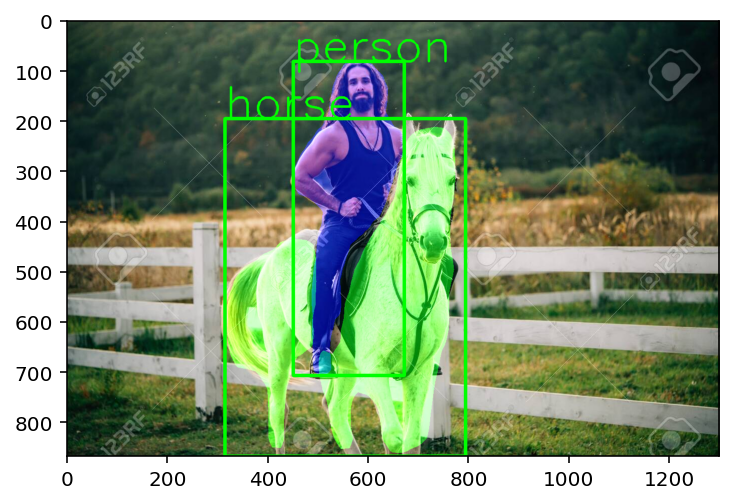

In [15]:
img, pred_classes, masks = instance_segmentation('./horse.jpg', rect_th=5, text_th=4)
plt.imshow(img)

In [16]:
!wget https://www.whoi.edu/wp-content/uploads/2021/07/graphics-SIPEX_P_Kimball-f16433856-c.jpg -O penguin.jpg

--2022-10-27 12:03:08--  https://www.whoi.edu/wp-content/uploads/2021/07/graphics-SIPEX_P_Kimball-f16433856-c.jpg
Resolving www.whoi.edu (www.whoi.edu)... 128.128.77.28
Connecting to www.whoi.edu (www.whoi.edu)|128.128.77.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184436 (180K) [image/jpeg]
Saving to: ‘penguin.jpg’

penguin.jpg         100%[===================>] 180.11K  1.02MB/s    in 0.2s    

2022-10-27 12:03:09 (1.02 MB/s) - ‘penguin.jpg’ saved [184436/184436]



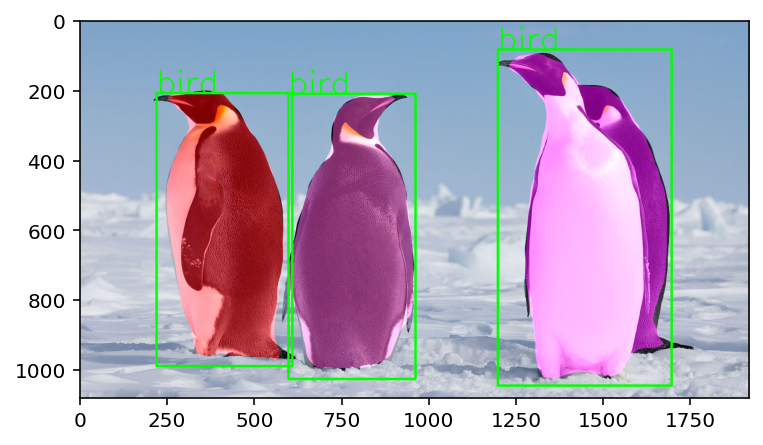

In [17]:
img, pred_classes, masks = instance_segmentation('./penguin.jpg', rect_th=5, text_th=4)
plt.imshow(img)

In [18]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Skateboarder_in_the_air.jpg/1200px-Skateboarder_in_the_air.jpg -O skateboard.jpg

--2022-10-27 12:03:10--  https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Skateboarder_in_the_air.jpg/1200px-Skateboarder_in_the_air.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382375 (373K) [image/jpeg]
Saving to: ‘skateboard.jpg’

skateboard.jpg      100%[===================>] 373.41K  --.-KB/s    in 0.02s   

2022-10-27 12:03:10 (18.3 MB/s) - ‘skateboard.jpg’ saved [382375/382375]



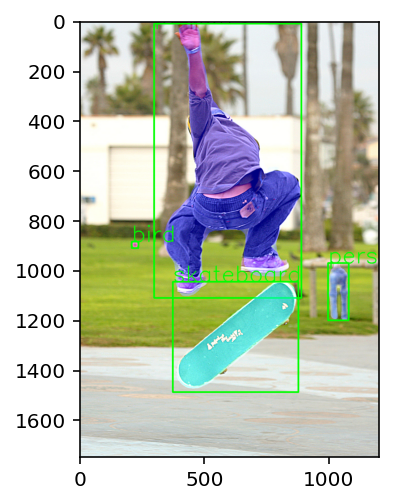

In [19]:
img, pred_classes, masks = instance_segmentation('./skateboard.jpg', rect_th=5, text_th=4)
plt.imshow(img)

In [22]:
!wget https://content.presspage.com/uploads/722/1920_236bus.jpg?10000 -O bus.jpg

--2022-10-27 12:07:12--  https://content.presspage.com/uploads/722/1920_236bus.jpg?10000
Resolving content.presspage.com (content.presspage.com)... 18.65.39.12, 18.65.39.78, 18.65.39.117, ...
Connecting to content.presspage.com (content.presspage.com)|18.65.39.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481717 (470K) [image/jpeg]
Saving to: ‘bus.jpg’

bus.jpg             100%[===================>] 470.43K  --.-KB/s    in 0.02s   

2022-10-27 12:07:12 (19.0 MB/s) - ‘bus.jpg’ saved [481717/481717]



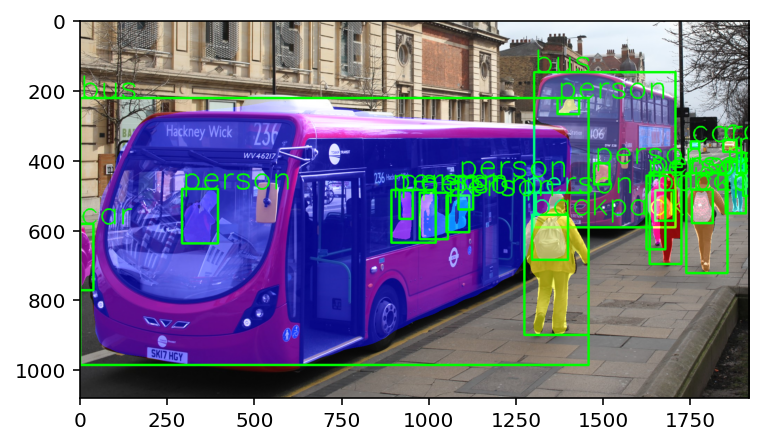

In [23]:
img, pred_classes, masks = instance_segmentation('./bus.jpg', rect_th=5, text_th=4)
plt.imshow(img)